# Fee Calculations

This notebook shows example fee split given assumptions about market making stake distribution, time weighting function, fee level and trading level. It has been used to generate Figure 1 in the ["Market Based Mechanisms for Incentivising Exchange Liquidity Provision"](https://vega.xyz/papers/liquidity.pdf) paper.

In [1]:
import numpy as np
import pandas as pd
from typing import Tuple, Sequence, Callable
import pylab as p
import time
import matplotlib.ticker as mtick

In [2]:
class MarketMakerStakes:
    _marketMakerId = 'Market_Maker_ID'
    _time ='Time'
    _stake = 'Stake'
    
    def __init__(self, marketMaturity: float, stakes: pd.DataFrame=None):
        if marketMaturity <= 0:
            raise ValueError("market maturity must be positive, got '{}'".format(marketMaturity))
        self.marketMaturity = marketMaturity
        self.stakes = pd.DataFrame(columns=[self._marketMakerId,self._time,self._stake])
        self._add_stakes(stakes)
        
    def __str__(self):
        return self.stakes.to_string()

    def marketMakerIDs(self):
        return self.stakes[self._marketMakerId].unique()
    
    def add_stake(self, marketMakerId: str, time: float, stake: float):
        if marketMakerId == "":
            raise ValueError("market maker ID cannot be empty")
        self._checkTime(time)
        if stake <= 0:
            raise ValueError("stake must be positive, got: '{}''".format(stake))
        self.stakes = self.stakes.append({self._marketMakerId: marketMakerId, self._time: time, self._stake: stake}, ignore_index=True)

    def compute_cumulative_stakes_at_t(self, time: float) -> pd.DataFrame:
        self._checkTime(time)
              
        df = self.stakes.copy()
        df.loc[df[self._time] > time, self._stake] = 0
        df = df.drop(columns=[self._time])
        return df.groupby(self._marketMakerId).sum()    
        
    def compute_fee_split_at_t(self, time: float, time_weighting_function: Callable[[float],float]) -> pd.DataFrame:
        self._checkTime(time)
        df = self.stakes.copy()
        df.loc[df[self._time] > time, self._stake] = 0
        df['timeWeightedStake'] = time_weighting_function(time-df[self._time].to_numpy(dtype=float))*df[self._stake]
        df['fee_fraction'] = df['timeWeightedStake'] / df['timeWeightedStake'].sum()
        df = df[[self._marketMakerId, 'fee_fraction']]
        return df.groupby(self._marketMakerId).sum()
    
    def _add_stakes(self, df: pd.DataFrame):
        if df is None:
            return
        self._checkColumnExists(df,self._marketMakerId)
        self._checkColumnExists(df,self._time)
        self._checkColumnExists(df,self._stake)
        self.stakes = self.stakes.append(df, ignore_index=True)

    def _checkColumnExists(self, df: pd.DataFrame, columnName: str):
        if not columnName in df.columns:
            raise ValueError("expecting a data frame with '{}' column'".format(columnName))
        
    def _checkTime(self,time: float):
        if time < 0 or time > self.marketMaturity:
            raise ValueError("invalid time: {} ∉ [0,{}]"
            .format(time,self.marketMaturity)) 

    def compute_fee_split(
        self,
        time_weighting_function: Callable[[float],float],
        timeLabelPairs: Sequence[Tuple[float, str]], 
        timeAxisLabel: str) -> pd.DataFrame:

        feeSplit = pd.DataFrame(columns=np.insert(self.marketMakerIDs(),0,timeAxisLabel))
        for i, tpl in enumerate(timeLabelPairs):
            splitAtT = self.compute_fee_split_at_t(tpl[0], time_weighting_function).squeeze()
            splitAtT[timeAxisLabel] = tpl[1]
            feeSplit.loc[i] = splitAtT
        return feeSplit

    def compute_cumulative_stakes(
        self,
        timeLabelPairs: Sequence[Tuple[float, str]], 
        timeAxisLabel: str) -> pd.DataFrame:

        df = pd.DataFrame(columns=np.insert(self.marketMakerIDs(),0,timeAxisLabel))
        for i, tpl in enumerate(timeLabelPairs):
            resultAtT = self.compute_cumulative_stakes_at_t(tpl[0]).squeeze()
            resultAtT[timeAxisLabel] = tpl[1]
            df.loc[i] = resultAtT
        return df
    
def compute_fee_revenue(stakes: MarketMakerStakes, feeFunction, dailyVolumeFunction, time_weighting_function, cumulative=True):
    timeAxisLabel = "time (y)"
    df = pd.DataFrame(columns=np.insert(stakes.marketMakerIDs(),0,timeAxisLabel)) 
    for i in range(1,366):
        t = i / 365.0
        splitAtT = stakes.compute_fee_split_at_t(t, time_weighting_function).squeeze()
        revenueAtT = splitAtT*feeFunction(t)*dailyVolumeFunction(t)
        revenueAtT[timeAxisLabel] = t
        df.loc[i] = revenueAtT
    if cumulative:
        df = pd.concat([df.iloc[:,0],df.iloc[:,1:].cumsum(axis=0)],axis=1)
    return df

def plot_fee_split(
    stakes: MarketMakerStakes,
    time_weighting_function: Callable[[float],float], 
    ax = None, 
    title=True,
    stacked=True, 
    showLegend=True, 
    plotKind="bar"):
    if ax == None:
        _, ax = p.subplots()
    feeSplit = stakes.compute_fee_split(time_weighting_function,[(i/12.0,str(i+1)) for i in range(0,12)],"month")
    plt = feeSplit.plot(kind=plotKind, stacked=stacked, x='month', rot = 0,ax=ax).legend(loc='lower left')
    if not showLegend:
        ax.get_legend().remove()
    titleText = 'Fee split'
    if title:
        ax.set_title(titleText)
    if not title:
        ax.set_ylabel(str.lower(titleText))
    ax.set_ylim([0,1])
    
def plot_fee_and_volume(feeFunction, dailyVolumeFunction, ax=None, timeInMonths=False,displayVolumes=True,title=True):
    offset = 0
    if ax == None:
        _, ax = p.subplots()
        offset = 1 # Needed for scales to agree when making this a subplot - looks like a bug in PyPlot
    t = np.linspace(0,1,365)
    volumes = [dailyVolumeFunction(x) for x in t]
    fees = [feeFunction(x) for x in t]

    color = p.rcParams['axes.prop_cycle'].by_key()['color'][-4]
    ax.set_xlabel('time (y)')
    
    if timeInMonths:
        ax.set_xlabel('month')
        t = offset + t * 12
    
    ax.set_ylabel('fee', color=color)  # we already handled the x-label with ax1
    ax.plot(t, fees, color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
        
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    color = p.rcParams['axes.prop_cycle'].by_key()['color'][-1]
    ax2.set_ylabel('volume', color=color)
    ax2.plot(t, volumes, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    if title:
        ax2.set_title('Fee and daily volume levels')
    ax2.get_yaxis().set_major_formatter(
        mtick.FuncFormatter(lambda x, _: format(int(x), ',') if displayVolumes else ''))

def plot_fee_revenue(stakes: MarketMakerStakes, feeFunction, dailyVolumeFunction, time_weighting_function, cumulative=True, ax=None, timeInMonths=False, title=True, showLegend=True):
    offset = 0
    if ax == None:
        _, ax = p.subplots()
        offset = 1 # Needed for scales to agree when making this a subplot - looks like a bug in PyPlot
    df = compute_fee_revenue(stakes, feeFunction,dailyVolumeFunction,time_weighting_function,cumulative)
    timeAxisLabel = "time (y)"
    
    if timeInMonths:
        df.iloc[:,0] = offset + df.iloc[:,0]*12
    df.plot.line(x=0, rot = 0, ax=ax).legend(loc='upper left')
    
    titleText = 'Cumulative fee revenue' if cumulative else "Fee revenue"
    if title:
        ax.set_title(titleText)
    if not title:
        ax.set_ylabel(str.lower(titleText))
    if not showLegend:
        ax.get_legend().remove()
    ax.get_yaxis().set_major_formatter(
    mtick.FuncFormatter(lambda x, p: format(int(x), ',')))
    if timeInMonths:
        p.xticks(np.arange(1,13))
        ax.set_xlabel("month")
    

    
def plot_cumulative_stakes(stakes: MarketMakerStakes, ax=None, title=True, stacked=False, showLegend=True, plotKind="bar"):
    if ax == None:
        _, ax = p.subplots()
    feeSplit = stakes.compute_cumulative_stakes([(i/12.0,str(i+1)) for i in range(0,12)],"month")
    plt = feeSplit.plot(kind=plotKind,stacked=stacked, x='month', rot = 0,ax=ax).legend(loc='lower right')
    if not showLegend:
        ax.get_legend().remove()
    titleText = 'Stake level'
    if title:
        ax.set_title(titleText)
    if not title:
        ax.set_ylabel(str.lower(titleText))
    ax.get_yaxis().set_major_formatter(
    mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

def plot_time_weighting_function(f, ax=None, title=True):
    if ax == None:
        _, ax = p.subplots()
    x = np.arange(0, 1, 0.01)
    y1 = f(x)
    ax.plot(x, y1,'r')
    ax.set_xlabel('time (y)')
    if title:
        ax.set_title('Weighting function')

def plot_multi(stakes, time_weighting_function, feeFunction, dailyVolumeFunction):
    fig = p.figure(figsize=(8, 7))
    ax1 = fig.add_subplot(2, 2, (1,2))
    ax2 = fig.add_subplot(2, 2, 3)
    ax3 = fig.add_subplot(2, 2, 4)
    plot_fee_revenue(stakes, feeFunction, dailyVolumeFunction, time_weighting_function,True,ax3)
    plot_cumulative_stakes(stakes,ax1)
    plot_fee_and_volume(feeFunction,dailyVolumeFunction,ax2)
    p.tight_layout()
    
def plot_stacked(stakes, time_weighting_function, feeFunction, dailyVolumeFunction, title1=True,title2=True,title3=True, title4=True):
    stakesStacked = True
    stakesPlotKind = 'area'
    feeSplitStacked = True
    feeSplitPlotKind = 'area'
    
    
    fig, axs = p.subplots(4, 1, sharex=True, figsize=(8,7))
    plot_fee_revenue(
        stakes, 
        feeFunction, 
        dailyVolumeFunction, 
        time_weighting_function,
        ax=axs[3], 
        cumulative=False, 
        timeInMonths=True,
        showLegend=False,
        title=title4)
    plot_fee_split(
        stakes,
        time_weighting_function,
        ax=axs[1], 
        plotKind=feeSplitPlotKind,
        stacked=feeSplitStacked,
        showLegend=False,
        title=title2)
    plot_cumulative_stakes(
        stakes,
        ax=axs[0],
        stacked=stakesStacked,
        showLegend=False,
        title=title1,
        plotKind=stakesPlotKind)
    plot_fee_and_volume(
        feeFunction,
        dailyVolumeFunction,
        ax=axs[2],
        timeInMonths=True,
        displayVolumes=True,
        title=title3)
    
    p.tight_layout()
    fig.align_ylabels(axs)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(
        handles, 
        labels, 
        loc='upper center', 
        fancybox=True, 
        shadow=False, 
        ncol=5, 
        bbox_to_anchor=(0.5, 1.025))


In [3]:
mmStakes = MarketMakerStakes(marketMaturity=1)
mmStakes.add_stake("MM#1",0,3e6)
mmStakes.add_stake("MM#2",0,1.5e6)
mmStakes.add_stake("MM#2",0.5,1.5e6)
mmStakes.add_stake("MM#3",0,7.5e5)
mmStakes.add_stake("MM#3",0.25,7.5e5)
mmStakes.add_stake("MM#3",0.5,7.5e5)
mmStakes.add_stake("MM#3",0.75,7.5e5)
mmStakes.add_stake("MM#4",0,2.5e5)
mmStakes.add_stake("MM#4",1./12,2.5e5)
mmStakes.add_stake("MM#4",2./12,2.5e5)
mmStakes.add_stake("MM#4",3./12,2.5e5)
mmStakes.add_stake("MM#4",4./12,2.5e5)
mmStakes.add_stake("MM#4",5./12,2.5e5)
mmStakes.add_stake("MM#4",6./12,2.5e5)
mmStakes.add_stake("MM#4",7./12,2.5e5)
mmStakes.add_stake("MM#4",8./12,2.5e5)
mmStakes.add_stake("MM#4",9./12,2.5e5)
mmStakes.add_stake("MM#4",10./12,2.5e5)
mmStakes.add_stake("MM#4",11./12,2.5e5)

print(mmStakes)

   Market_Maker_ID       Time      Stake
0             MM#1          0  3000000.0
1             MM#2          0  1500000.0
2             MM#2        0.5  1500000.0
3             MM#3          0   750000.0
4             MM#3       0.25   750000.0
5             MM#3        0.5   750000.0
6             MM#3       0.75   750000.0
7             MM#4          0   250000.0
8             MM#4  0.0833333   250000.0
9             MM#4   0.166667   250000.0
10            MM#4       0.25   250000.0
11            MM#4   0.333333   250000.0
12            MM#4   0.416667   250000.0
13            MM#4        0.5   250000.0
14            MM#4   0.583333   250000.0
15            MM#4   0.666667   250000.0
16            MM#4       0.75   250000.0
17            MM#4   0.833333   250000.0
18            MM#4   0.916667   250000.0


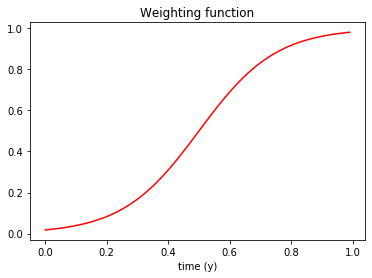

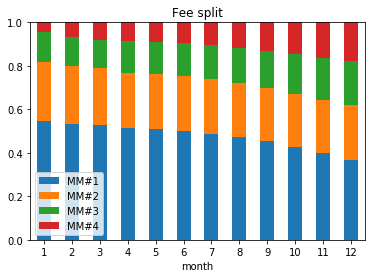

In [4]:
def time_weighting_function(x):
    xmid = 0.5
    k = 8
    return 1.0 / (1.0 + np.exp(-k*(x-xmid)))

plot_time_weighting_function(time_weighting_function)
plot_fee_split(mmStakes,time_weighting_function)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


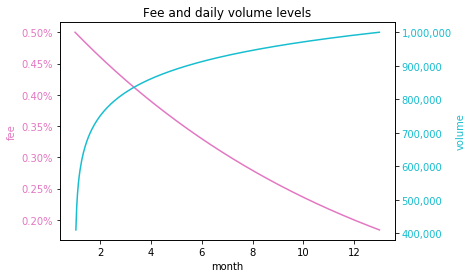

In [5]:
def fee_level(x):
    return 0.005*np.exp(-x)
def daily_traded_volume(x):
    return 1e5*(10+np.log(x))

plot_fee_and_volume(fee_level,daily_traded_volume,timeInMonths=True)

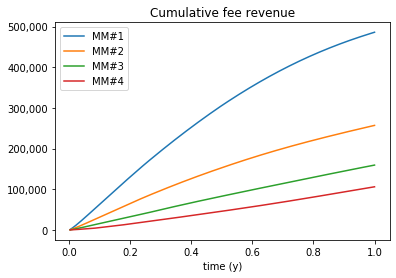

In [6]:
plot_fee_revenue(mmStakes, fee_level, daily_traded_volume, time_weighting_function,True)

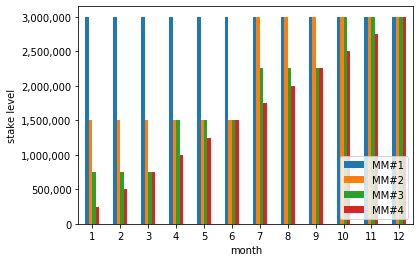

In [7]:
plot_cumulative_stakes(mmStakes,title=False)

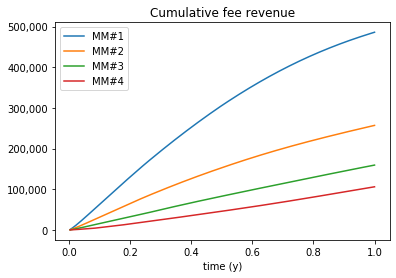

In [8]:
plot_fee_revenue(mmStakes, fee_level, daily_traded_volume, time_weighting_function,True)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


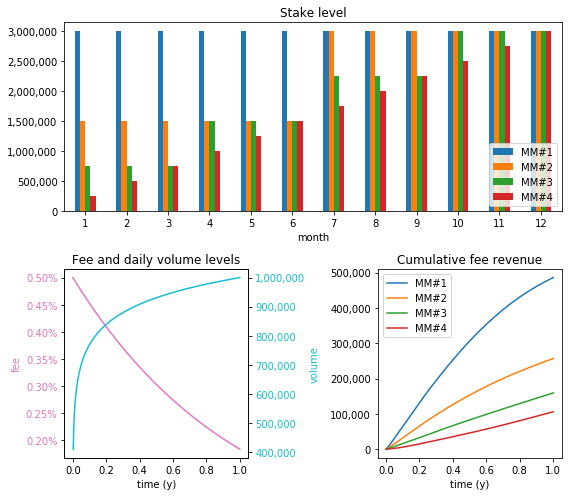

In [9]:
plot_multi(mmStakes, time_weighting_function, fee_level, daily_traded_volume)

Chart used in the ["Market Based Mechanisms for Incentivising Exchange Liquidity Provision"](https://vega.xyz/papers/liquidity.pdf) paper:

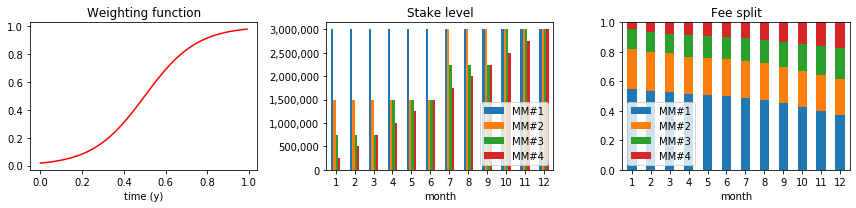

In [10]:
fig = p.figure(figsize=(12,3))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3,3)

plot_time_weighting_function(time_weighting_function, ax1)
plot_cumulative_stakes(mmStakes,ax2)
plot_fee_split(mmStakes,time_weighting_function,ax3)
p.tight_layout()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


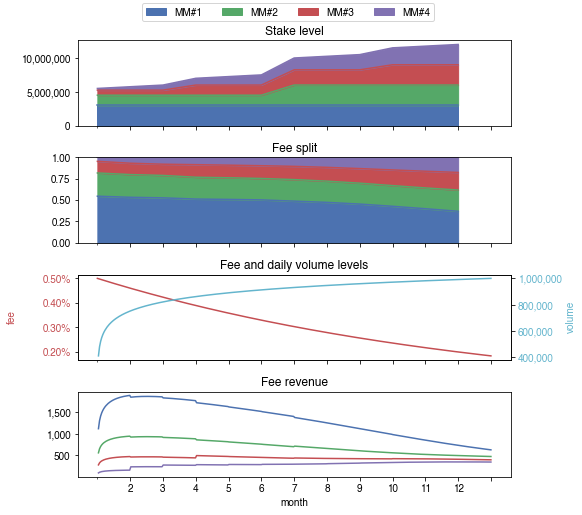

In [11]:
p.style.use('seaborn-deep') 
#p.style.use('dark_background') 
#For more styles see: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
#Restarting the kernel is sometimes needed to make it look as it's meant to

#from matplotlib import rcParams
p.rcParams['font.family'] = 'sans-serif'
p.rcParams['font.sans-serif'] = ['Helvetica']

plot_stacked(mmStakes, time_weighting_function, fee_level, daily_traded_volume)


## Hypothetical scenario

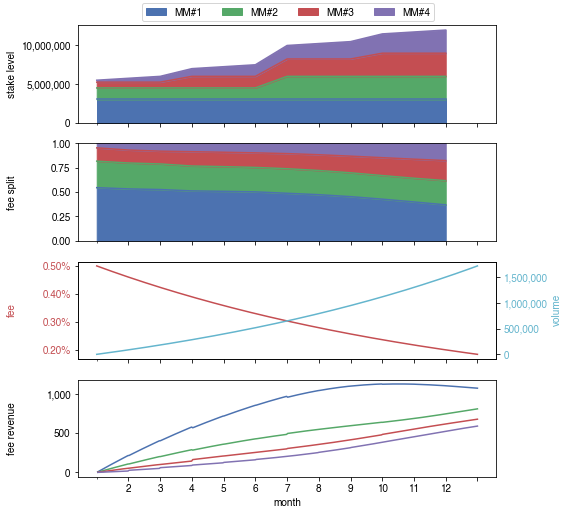

In [12]:
fee = lambda x: 0.005*np.exp(-x)
volume = lambda x: 1e4*(100*np.exp(x) - 100)
weighting = lambda x: 1.0 / (1.0 + np.exp(-8*(x-0.5)))

stakes = MarketMakerStakes(marketMaturity=1)
stakes.add_stake("MM#1",0,3e6)
stakes.add_stake("MM#2",0,1.5e6)
stakes.add_stake("MM#2",0.5,1.5e6)
stakes.add_stake("MM#3",0,7.5e5)
stakes.add_stake("MM#3",0.25,7.5e5)
stakes.add_stake("MM#3",0.5,7.5e5)
stakes.add_stake("MM#3",0.75,7.5e5)
stakes.add_stake("MM#4",0,2.5e5)
stakes.add_stake("MM#4",1./12,2.5e5)
stakes.add_stake("MM#4",2./12,2.5e5)
stakes.add_stake("MM#4",3./12,2.5e5)
stakes.add_stake("MM#4",4./12,2.5e5)
stakes.add_stake("MM#4",5./12,2.5e5)
stakes.add_stake("MM#4",6./12,2.5e5)
stakes.add_stake("MM#4",7./12,2.5e5)
stakes.add_stake("MM#4",8./12,2.5e5)
stakes.add_stake("MM#4",9./12,2.5e5)
stakes.add_stake("MM#4",10./12,2.5e5)
stakes.add_stake("MM#4",11./12,2.5e5)

plot_stacked(
    stakes, 
    weighting, 
    fee, 
    volume,
    title1 = False,
    title2 = False,
    title3 = False,
    title4 = False)